In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
from salishsea_tools import Keegan_eval_tools as ket
import json
from collections import OrderedDict
from matplotlib.colors import LogNorm
import arrow
import glob
import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,0:27,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [3]:
np.shape(tmask)

(27, 898, 398)

## Bring in grid coordinates for slice/box of interest

In [4]:
ii, ij = 450,500
ji, jj = 250,300


In [5]:
CentralSoG = [450, 500,250,300]

In [6]:
yearList = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

data = 'month-avg.202111'
#year = '2014'
month = '01'
file = 'biol'

for year in yearList:
    files=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

In [7]:
## Gathering metadata but still not opening the files
dsfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['ammonium', 'silicon', \
                        'dissolved_organic_nitrogen', \
                        'particulate_organic_nitrogen', 'biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

In [8]:
np.shape(CentralSoG)

(4,)

In [9]:
np.shape(dsfiles.time)

(192,)

In [10]:
dsfiles.microzooplankton

<xarray.DataArray 'microzooplankton' (time: 192, depth: 40, gridY: 898,
                                      gridX: 398)> Size: 11GB
dask.array<concatenate, shape=(192, 40, 898, 398), dtype=float32, chunksize=(1, 40, 898, 398), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 2007-01-15T12:00:00 ... 2022-12-15T12:...
  * depth    (depth) float32 160B 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * gridY    (gridY) int64 7kB 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * gridX    (gridX) int64 3kB 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
Attributes:
    standard_name:  mole_concentration_of_microzooplankton_expressed_as_nitro...
    long_name:      Microzooplankton Concentration
    units:          mmol m-3

In [11]:
np.shape(tmask) 

(27, 898, 398)

In [12]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [13]:
newmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,27,50,50))

In [14]:
np.shape(newmask) 

(192, 27, 50, 50)

In [15]:
tt=np.array(dsfiles.time)
mod_depth=np.array(dsfiles.depth)
mod_microzooplankton=(dsfiles.microzooplankton[:,0:27, CentralSoG[0]:CentralSoG[1], ### choose for 5 m only
                               CentralSoG[2]:CentralSoG[3]])
mod_microzooplankton = (np.array(mod_microzooplankton))

mod_microzooplankton = np.ma.masked_where(newmask==0,mod_microzooplankton) ## masking where there is land

mod_mesozooplankton=(dsfiles.mesozooplankton[:,0:27, CentralSoG[0]:CentralSoG[1], ### choose for 5 m only
                               CentralSoG[2]:CentralSoG[3]])
mod_mesozooplankton = (np.array(mod_microzooplankton))

mod_mesozooplankton = np.ma.masked_where(newmask==0,mod_mesozooplankton) ## masking where there is land

In [16]:
dsfiles.close()

In [17]:
mod_microzooplankton = mod_microzooplankton.T ## transpose the variable to make it work with the Hovmoller plots

In [18]:
mod_mesozooplankton = mod_mesozooplankton.T

In [19]:
np.shape(mod_microzooplankton)

(50, 50, 27, 192)

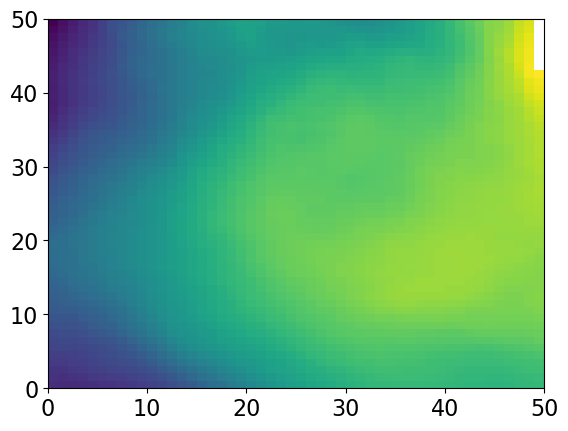

In [20]:
## Check to see what is there

plt.pcolormesh(mod_microzooplankton[:,:,0,0]) ## viewing the first depth at the first time stamp; remember z and t are the last two axes here


In [21]:
mod_zoop=(mod_microzooplankton+mod_mesozooplankton)*5.7*12 ## C:N ratio for zooplankton

In [22]:
mod_zoop_mean=np.mean(mod_zoop, axis=(0, 1,2)) ## calculate the mean across the entire slice/box 4d to 2d array and entire depth range

In [23]:
mod_zoop_std=np.std(mod_zoop, axis=(0, 1,2)) ## calculate the sem across the entire slice/box 4d to 2d array and entire depth range

Text(0.5, 1.0, 'Model Z1+Z2 0-100 m')

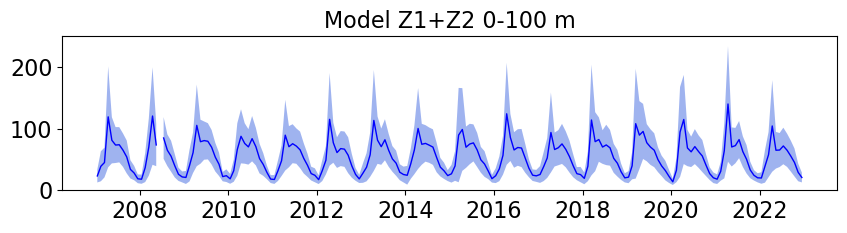

In [24]:
fig,ax=plt.subplots(1,1,figsize=(10,2))


#ax.errorbar(tt,(mod_microzooplankton_mean-mod_microzooplankton_std)*1.8,(mod_microzooplankton_mean+mod_microzooplankton_std,)*1.8)

ax.errorbar(tt, mod_zoop_mean,label='',color='b',linestyle='-',linewidth=1)
ax.fill_between(tt, (mod_zoop_mean-mod_zoop_std), (mod_zoop_mean+mod_zoop_std),
    alpha=0.5, edgecolor='royalblue', facecolor='royalblue',
    linewidth=0)
ax.set_ylim(0,250)
ax.set_title('Model Z1+Z2 0-100 m')

In [25]:
data=pd.read_excel('MHWCanadianZoopBiomassDF.xlsx',engine='openpyxl')

In [26]:
data.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Station', 'Lon', 'Lat', 'Date',
       'dtUTC', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'Z_lower', 'Z_upper',
       'Bottom Depth(m)', 'Amphipoda', 'Thecostraca', 'Decapoda',
       'Euphausiacea', 'Aphragmophora', 'Leptothecate', 'Trachylina',
       'Anthoathecatae', 'Phragmophora', 'Calanoida', 'Cyclopoida',
       'Poecilostomatoida', 'Copelata', 'Harpacticoida', 'Thecosomata',
       'Phaeogromia', 'Noctilucales', 'Foraminiferida', 'Monstrilloida',
       'Year', 'Month', 'YD', 'Amphipods', 'Decapods', 'Euphausiids',
       'Calanoids'],
      dtype='object')

In [27]:
data['dtUTC']=pd.to_datetime(data['dtUTC']) 

In [28]:
data['dtUTC']

0      2016-10-24 17:19:00
1      2016-11-10 17:50:00
2      2016-12-05 21:29:00
3      2016-12-14 18:00:00
4      2017-01-05 19:30:00
               ...        
2406   2005-05-13 19:00:00
2407   2005-05-13 19:15:00
2408   2005-06-23 19:00:00
2409   2005-06-23 19:15:00
2410   2005-09-24 19:15:00
Name: dtUTC, Length: 2411, dtype: datetime64[ns]

In [29]:
data['Year']=[ii.year for ii in data['dtUTC']]
data['Month']=[ii.month for ii in data['dtUTC']]
#data['YD']=et.datetimeToYD(data['time'])

In [30]:
data['Year']

0       2016
1       2016
2       2016
3       2016
4       2017
        ... 
2406    2005
2407    2005
2408    2005
2409    2005
2410    2005
Name: Year, Length: 2411, dtype: int64

In [31]:
data['YMO']=pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

In [32]:
data=data[(data['region_name'] <= 'Central Strait of Georgia')] #

In [33]:
data=data[(data['Year'] >= 2007) & (data['Year'] <= 2022)]

In [34]:
#data=data[(data['Z'] <= 20)] #

In [35]:
## NEED COLUMN TO TOTAL ALL ZOOPLANKTON DATA
data.keys()


Index(['Unnamed: 0', 'Key', 'region_name', 'Station', 'Lon', 'Lat', 'Date',
       'dtUTC', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'Z_lower', 'Z_upper',
       'Bottom Depth(m)', 'Amphipoda', 'Thecostraca', 'Decapoda',
       'Euphausiacea', 'Aphragmophora', 'Leptothecate', 'Trachylina',
       'Anthoathecatae', 'Phragmophora', 'Calanoida', 'Cyclopoida',
       'Poecilostomatoida', 'Copelata', 'Harpacticoida', 'Thecosomata',
       'Phaeogromia', 'Noctilucales', 'Foraminiferida', 'Monstrilloida',
       'Year', 'Month', 'YD', 'Amphipods', 'Decapods', 'Euphausiids',
       'Calanoids', 'YMO'],
      dtype='object')

In [36]:
data['Total']=((data['Amphipoda']+ data['Thecostraca']+ data['Decapoda']+
       (data['Euphausiacea']*3)+ data['Aphragmophora']+ data['Leptothecate']+ data['Trachylina']+
       data['Anthoathecatae']+ data['Phragmophora']+ data['Calanoida']+ data['Cyclopoida']+
       data['Poecilostomatoida']+ data['Copelata']+ data['Harpacticoida']+ data['Thecosomata']+
       data['Phaeogromia']+ data['Noctilucales']+ data['Foraminiferida']+ data['Monstrilloida'])*0.45)

#biomassDF['Calanoida']+biomassDF['Cyclopoida']

In [37]:
data

,Unnamed: 0,Key,region_name,Station,Lon,Lat,Date,dtUTC,Twilight,Net_Type,...,Monstrilloida,Year,Month,YD,Amphipods,Decapods,Euphausiids,Calanoids,YMO,Total
177,177,IOS2007001013101,Central Strait of Georgia,GEO1,-123.750,49.250,2/22/2007,2007-02-23 06:57:00,Night,Bongo VNH,...,0.0,2007,2,54,3.008700,0.312372,0.182241,0.000000,2007-02-01,6.125936
178,178,IOS2007001013201,Central Strait of Georgia,GEO1,-123.748,49.250,2/22/2007,2007-02-23 07:09:00,Night,Bongo VNH,...,0.0,2007,2,54,0.698297,0.362308,0.237591,0.000000,2007-02-01,2.113079
179,179,IOS2007012011101,Central Strait of Georgia,GEO1,-123.747,49.249,5/28/2007,2007-05-28 18:35:00,Daylight,Bongo VNH,...,0.0,2007,5,148,3.155521,1.251076,9.020052,0.000000,2007-05-01,34.190653
180,180,IOS2007014005001,Central Strait of Georgia,GEO1,-123.737,49.248,6/30/2007,2007-06-30 19:53:00,Daylight,Bongo VNH,...,0.0,2007,6,181,3.667563,0.919463,1.705095,0.000000,2007-06-01,27.659039
181,181,IOS2007014005101,Central Strait of Georgia,GEO1,-123.737,49.248,6/30/2007,2007-06-30 20:12:00,Daylight,Bongo VNH,...,0.0,2007,6,181,4.565736,0.927653,0.226008,0.000000,2007-06-01,7.743883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,2335,UBC9999099001301,Central Strait of Georgia,S4-1.5,-123.667,49.250,8/26/2018,2018-08-26 19:40:00,Daylight,Bongo VNH,...,0.0,2018,8,238,9.213174,0.191795,4.486977,0.000000,2018-08-01,25.105036
2337,2337,UBC9999099001601,Central Strait of Georgia,ND1,-123.470,49.228,8/30/2016,2016-08-30 19:00:00,Daylight,Bongo VNH,...,0.0,2016,8,243,22.385763,0.031068,1.031931,0.000000,2016-08-01,32.187474
2338,2338,UBC9999099001801,Central Strait of Georgia,S4-1.5,-123.667,49.250,12/4/2017,2017-12-04 20:00:00,Daylight,Bongo VNH,...,0.0,2017,12,338,0.986004,0.056574,0.270400,0.000000,2017-12-01,2.420019
2339,2339,UBC9999099001901,Central Strait of Georgia,S4-1.5,-123.667,49.250,1/15/2018,2018-01-15 20:00:00,Daylight,Bongo VNH,...,0.0,2018,1,15,2.241436,0.011412,0.219060,0.000000,2018-01-01,3.583849


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


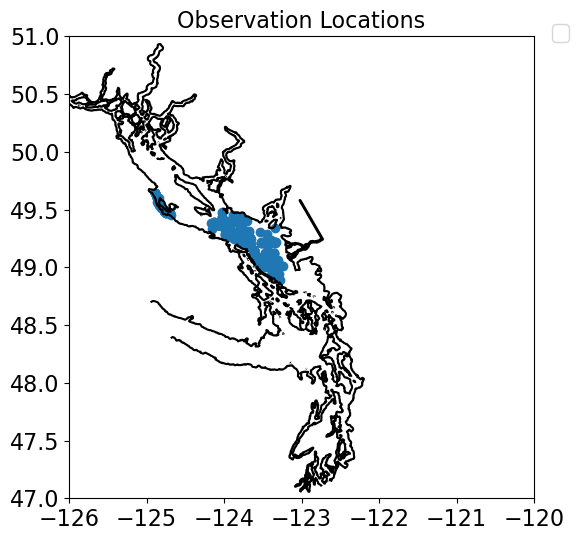

In [38]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(data['Lon'], data['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [39]:

data=data.dropna(subset=['Total'])

In [40]:
obs_zoop=data['Total'].groupby(data['YMO']).mean()

In [41]:
obs_zoop

YMO
2007-02-01     3.613154
2007-04-01    11.245043
2007-05-01    34.190653
2007-06-01    17.701461
2007-09-01     8.357479
                ...    
2019-05-01    41.696483
2019-06-01    68.866909
2019-07-01    27.583783
2019-09-01    46.444201
2019-10-01    25.883608
Name: Total, Length: 87, dtype: float64

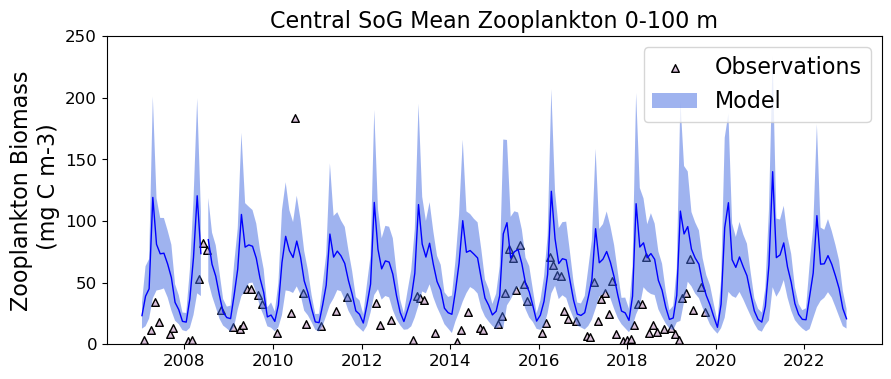

In [55]:

fig,ax=plt.subplots(1,1,figsize=(10,4))

ax.scatter(obs_zoop.index,obs_zoop,marker='^',color='thistle',edgecolor='k',s=30,label='Observations')
ax.set_ylim(0,250)
ax.set_title('Central SoG Mean Zooplankton 0-100 m')
#ax.errorbar(tt,(mod_microzooplankton_mean-mod_microzooplankton_std)*1.8,(mod_microzooplankton_mean+mod_microzooplankton_std,)*1.8)

ax.errorbar(tt, mod_zoop_mean,label='',color='b',linestyle='-',linewidth=1)
ax.fill_between(tt, (mod_zoop_mean-mod_zoop_std), (mod_zoop_mean+mod_zoop_std),
    alpha=0.5, edgecolor='royalblue', facecolor='royalblue',
    linewidth=0,label='Model')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel('Zooplankton Biomass\n (mg C m-3)')
ax.legend(frameon=True)


In [43]:
print(mod_zoop_mean.min()) 
print(mod_zoop_mean.max())

13.76068847328813
140.09032113851427


In [44]:
print(obs_zoop.min()) 
print(obs_zoop.max())

2.0348358749999997
183.74685412499997
